# Demonstration for Time series forecasting

Forecasting for the count infected by COVID-19 (USA)

Author: Jim Xie

Date: 2020-7-20

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import json
plt.style.use({'figure.figsize':(12, 5)})
sns.set_style('dark')
sns.set_context("poster")
#np.set_printoptions(suppress=True,   precision=10,  threshold=2000,  linewidth=150)  
pd.set_option('display.float_format',lambda x : '%.2f' % x)
plt.rcParams['axes.unicode_minus'] = False
from warnings import filterwarnings
filterwarnings('ignore')

# Prepare train data

In [107]:
df = pd.read_csv('./US/us_states_covid19_daily.csv')
df = pd.read_csv('./US-812/us_states_covid19_daily.csv')
df = pd.read_csv('./US-830/us_states_covid19_daily.csv')
del df['hash']
del df['commercialScore']
del df['negativeRegularScore']
del df['negativeScore']
del df['positiveScore']
del df['score']
del df['grade']
del df['hospitalizedIncrease']
del df['deathIncrease']
del df['hospitalizedCumulative']
del df['hospitalizedCurrently']
del df['inIcuCurrently']
del df['inIcuCumulative']
del df['onVentilatorCurrently']
del df['onVentilatorCumulative']
del df['recovered']
del df['lastUpdateEt']
del df['dateModified']
del df['checkTimeEt']
del df['dateChecked']
df['date'] = df['date'].astype(str)
df.fillna(value=0,inplace=True)
df.head(5)

,date,state,positive,negative,pending,dataQualityGrade,death,hospitalized,totalTestsViral,positiveTestsViral,...,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsSource,totalTestResults,totalTestResultsIncrease,posNeg
0,20200829,AK,6035.00,339660.00,0.00,A,37.00,0.00,345695.00,5558.00,...,0.00,0.00,2,112,6045,345695,posNeg,345695.00,6157,345695
1,20200829,AL,123889.00,851929.00,0.00,B,2152.00,14267.00,967213.00,0.00,...,0.00,0.00,1,1704,9251,975818,posNeg,975818.00,10955,975818
2,20200829,AR,60378.00,646592.00,0.00,A,772.00,4142.00,706970.00,0.00,...,3610.00,0.00,5,795,8120,706970,posNeg,706970.00,8915,706970
3,20200829,AS,0.00,1514.00,0.00,C,0.00,0.00,0.00,0.00,...,0.00,0.00,60,0,0,1514,posNeg,1514.00,0,1514
4,20200829,AZ,201287.00,991089.00,0.00,A+,5007.00,21433.00,1190668.00,0.00,...,0.00,0.00,4,629,7670,1192376,posNeg,1192376.00,8299,1192376


In [108]:
def GetRawSamples():
    df2 = pd.DataFrame()
    df2['date'] = df['date']
    df2['state'] = df['state']
    df2['positive']=df['positive']
    df2['positiveIncrease']=df['positiveIncrease']
    df2['test'] = df['total']
    df2['testIncrease'] = df['totalTestResultsIncrease']
    df2.sort_values('date',ascending=True,inplace=True)
    df2 = df2[df2['date']>='20200401']
    df2 = df2.reset_index()
    del df2['index']
    return df2

def GetSamples(state = None):
    dr = GetRawSamples()
    if state:
        dr = dr[dr['state']==state]
    else:
        dr = dr.groupby(['date'])['positive','positiveIncrease','test','testIncrease'].agg('sum')
        #dr = dr.to_frame().reset_index()
        dr['state'] = 'ALL'
    dr.sort_values('date',ascending=True,inplace=True)
    dr = dr.reset_index()
    return dr

In [109]:
#ADF Test result同时小于1%、5%、10%
#P-value (不变显著性) 接近0。
def check_stationarity(timeSeries):
    dftest = adfuller(timeSeries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    del dfoutput['#Lags Used']
    del dfoutput['Number of Observations Used']
    return dfoutput

<AxesSubplot:>

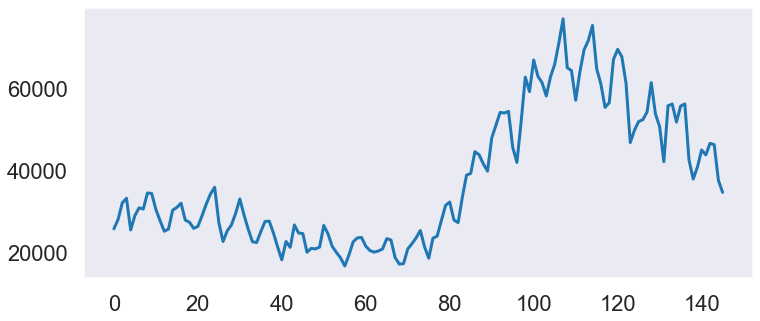

In [110]:
df0 = GetSamples()
verify_count = 5
df_verify = df0.tail(verify_count)
df0.drop(df0.tail(verify_count).index,inplace=True)
data = pd.DataFrame()
raw_data = df0['positiveIncrease']
raw_date = df0['date']
log_data = np.log(raw_data)
raw_data.plot()

In [111]:
check_stationarity(raw_data)

Test Statistic         -1.74
p-value                 0.41
Critical Value (1%)    -3.48
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64

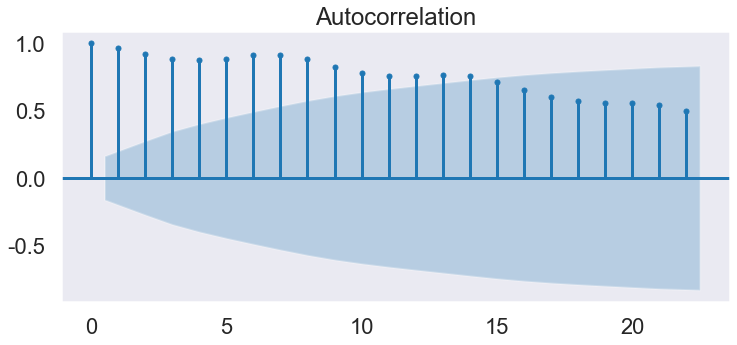

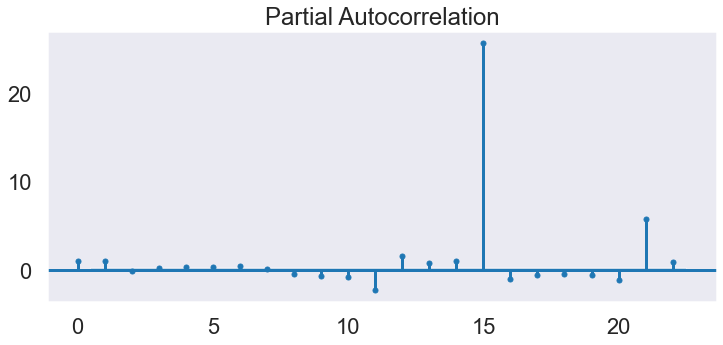

In [112]:
plot_acf(raw_data).show()
plot_pacf(raw_data).show()

In [113]:
data_mean = raw_data.rolling(window=7).mean()
data_mean.dropna(inplace=True)

In [114]:
check_stationarity(data_mean)

Test Statistic         -2.09
p-value                 0.25
Critical Value (1%)    -3.48
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64

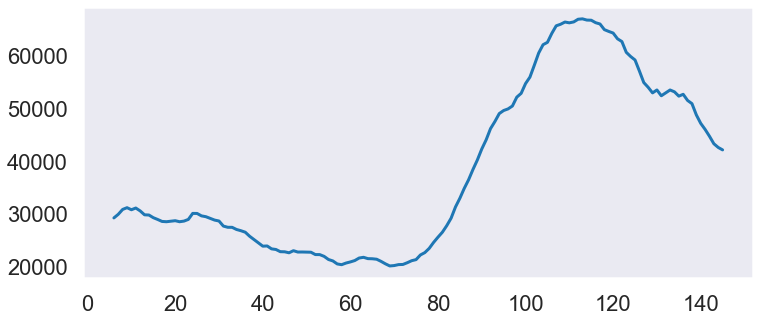

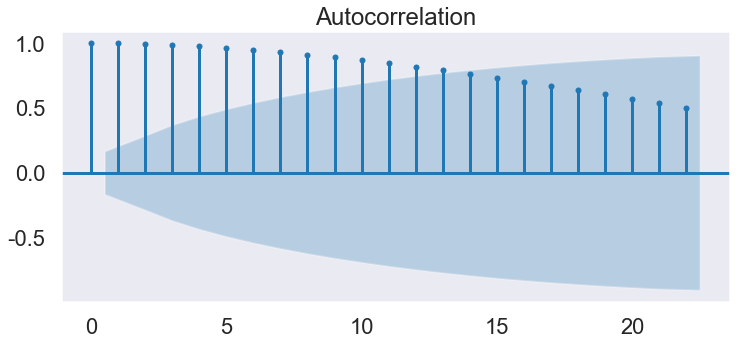

In [115]:
data_mean.plot()
plot_acf(data_mean).show()

In [116]:
data_diff_1 = data_mean.diff(1)
data_diff_1.dropna(inplace=True)
data_diff_2 = data_diff_1.diff(1)
data_diff_2.dropna(inplace=True)
#data_diff_3 = data_diff_2.diff(1)
#data_diff_3.dropna(inplace=True)
#check_stationarity(data_diff_3)

In [117]:
check_stationarity(data_diff_1)

Test Statistic         -1.57
p-value                 0.50
Critical Value (1%)    -3.48
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64

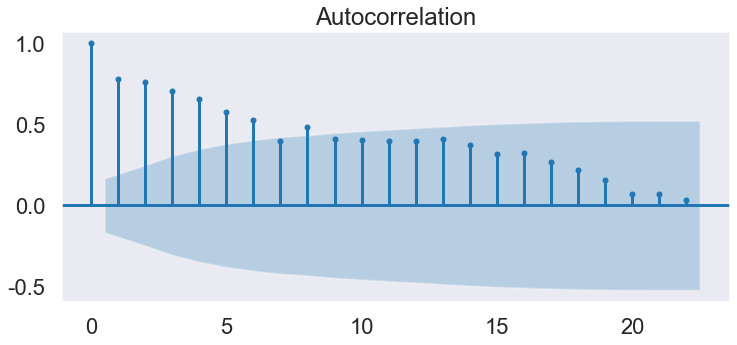

In [118]:
plot_acf(data_diff_1).show()

In [119]:
check_stationarity(data_diff_2)

Test Statistic         -3.15
p-value                 0.02
Critical Value (1%)    -3.48
Critical Value (5%)    -2.88
Critical Value (10%)   -2.58
dtype: float64

<AxesSubplot:>

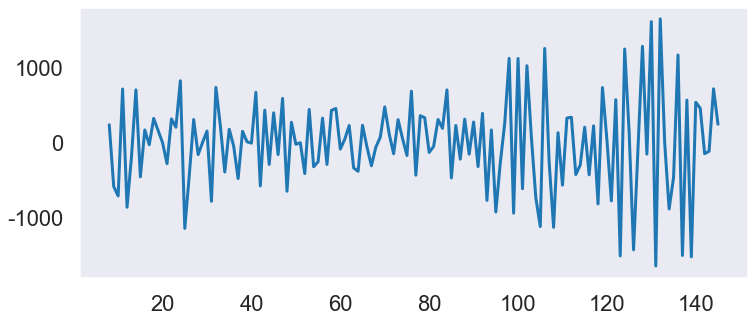

In [120]:
data_diff_2.plot()

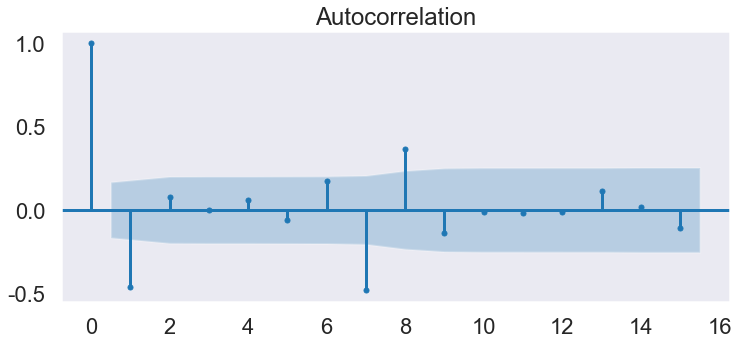

In [121]:
plot_acf(data_diff_2,lags=15).show()

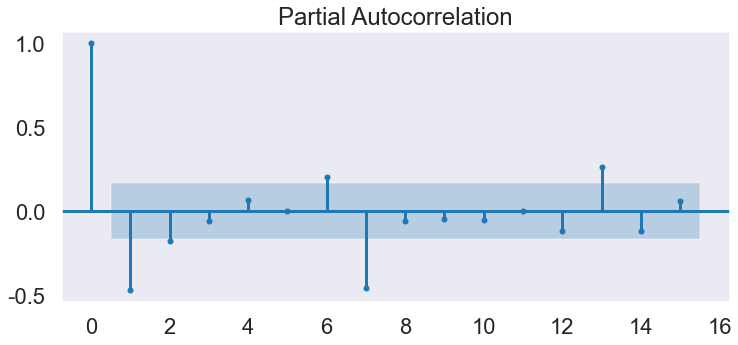

In [122]:
plot_pacf(data_diff_2,lags=15).show()

# 模型选择

In [123]:
train_data = raw_data.copy()

rol_mean = log_data.rolling(window=7).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)

ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)

def show_result(ts,log_recover,error):
    plt.figure(facecolor='white')
    log_recover.plot(color='blue', label='Predict')
    ts.plot(color='red', label='Original')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% error)
    plt.show()

Test with ARIMA recommand params

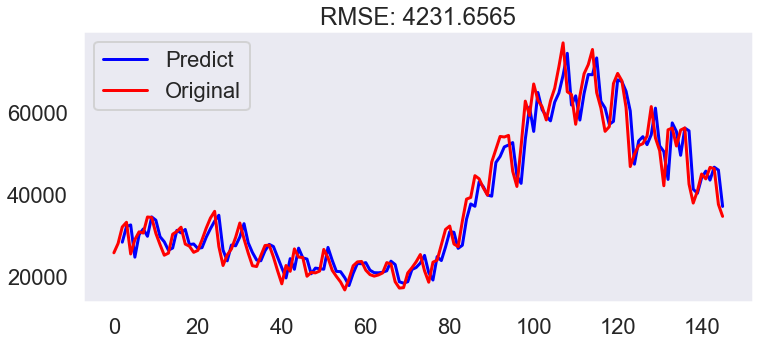

In [124]:
train_data = raw_data.copy()
train_data = train_data.astype("float64")

result_arima = ARIMA(train_data, order=(2, 0, 3)).fit( disp=-1, method='css')
predicted = result_arima.predict()
error = (np.sqrt(sum((predicted-train_data).dropna()**2/train_data.size)))
show_result(train_data,predicted,error)

3 0 3


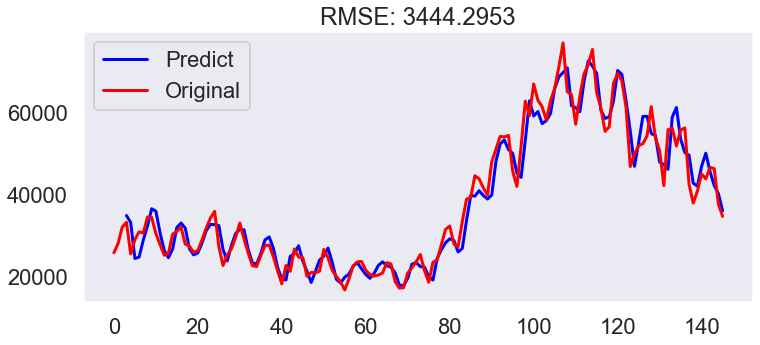

In [125]:
train_data = raw_data.copy()
train_data = train_data.astype("float64")

result_arima = None
min_error = 65536
min_predicted = None
min_p = None
min_q = None
min_d = None
for p in range(4):
    for q in range(4):
        for d in range(2):
          
            try:
                model = ARIMA(train_data, order=(p, d, q))
                res_arima = model.fit( disp=-1, method='css')
                predicted = res_arima.predict()
                error = (np.sqrt(sum((predicted-train_data).dropna()**2/train_data.size)))
                if error < min_error:
                    result_arima = res_arima
                    min_predicted = predicted
                    min_error = error
                    min_p = p
                    min_d = d
                    min_q = q
            except:
                pass
print(min_p,min_d,min_q)
show_result(train_data,min_predicted,min_error)

In [127]:
predict_ts=result_arima.forecast(verify_count)  
for i in range(verify_count):
    real = df_verify.iloc[i]['positiveIncrease']
    real_date = df_verify.iloc[i]['date']
    predicted = int(predict_ts[0][i])
    
    diff = abs(predicted-real)
    rate = "%.4f"%(diff*100/real)
    print(real_date,"real:",real, " pred :",predicted, " error :",diff," rate :",rate)

20200825 real: 36374  pred : 37022  error : 648  rate : 1.7815
20200826 real: 43356  pred : 41968  error : 1388  rate : 3.2014
20200827 real: 43984  pred : 46141  error : 2157  rate : 4.9041
20200828 real: 46546  pred : 46350  error : 196  rate : 0.4211
20200829 real: 44328  pred : 42413  error : 1915  rate : 4.3201


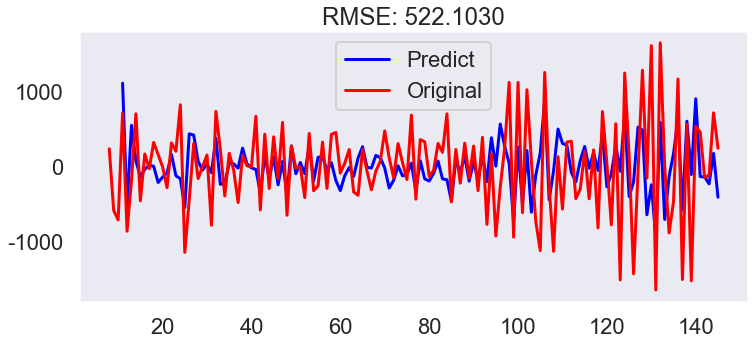

In [128]:
train_data = data_diff_2.astype("float64")

model = ARIMA(train_data, order=(3, 0, 2))
result_arima = model.fit( disp=-1, method='css')
predicted = result_arima.predict()

min_error = (np.sqrt(sum((predicted-train_data).dropna()**2/train_data.size)))
show_result(train_data,predicted,min_error)


<AxesSubplot:>

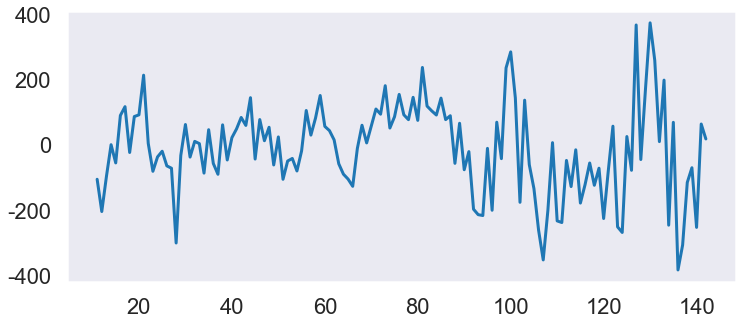

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_diff_2, period=7,model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
trend.dropna(inplace=True)
seasonal.dropna(inplace=True)
residual.dropna(inplace=True)
trend.plot()

<AxesSubplot:>

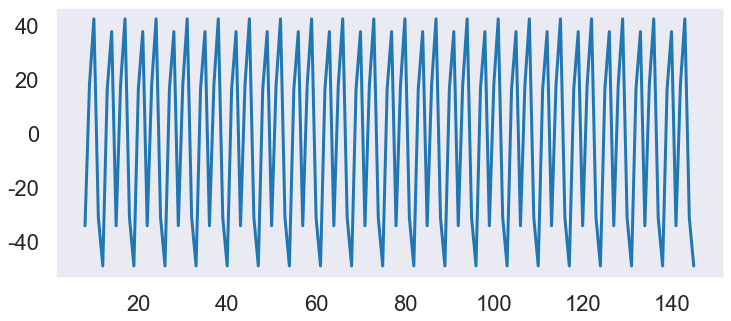

In [130]:
seasonal.plot()

<AxesSubplot:>

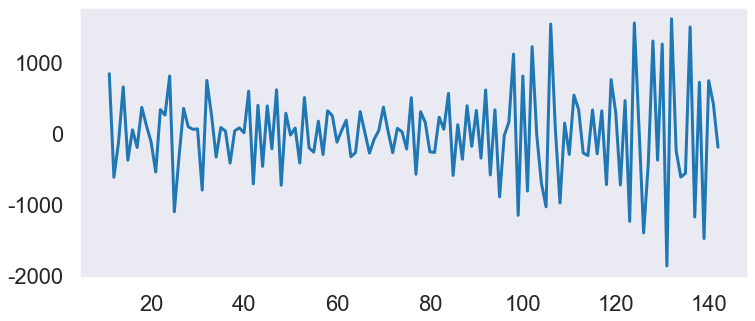

In [131]:
residual.plot()